<a href="https://colab.research.google.com/github/VigneshDev16/MachineLearning_Part1/blob/main/Machine_Learning_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Assignment 2 – IIT Mandi (IITMDDSAI 2505)
Author: Vigneshwaran

Dataset: Company_Data.csv Note: Run this notebook in Google Colab → Upload Company_Data.csv when prompted.

Library Imports and Global Settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import math
from google.colab import files
uploaded = files.upload()

# Set a random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Set global plot style
plt.style.use('ggplot')


Saving Company_Data.csv to Company_Data.csv


Data Loading and Target Creation

In [ ]:
# Load the dataset
DATA_FILENAME = 'Company_Data.csv'
df = pd.read_csv(DATA_FILENAME)
print(df.head())
file_name = 'Company_Data.csv'
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print("Please ensure 'Company_Data.csv' is uploaded to the Colab environment.")
    exit()

# --- Data Preprocessing ---

# 1. Create the binary target variable 'Sales_High'
# Objective: Identify attributes that drive "High" sales.
# Approach: Use the median of sales as the cutoff (1 for High, 0 for Low).
sales_median = df['Sales'].median()
df['Sales_High'] = np.where(df['Sales'] >= sales_median, 1, 0)

# Drop the original continuous 'Sales' column
df = df.drop('Sales', axis=1)

print(f"Sales Median used for cutoff: {sales_median:.2f}")
print("Distribution of Sales_High (1: High, 0: Low):")
print(df['Sales_High'].value_counts())

# 2. Handle Categorical Features (One-Hot Encoding)
# Categorical columns: 'ShelveLoc', 'Urban', 'US'
df = pd.get_dummies(df, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

# 3. Prepare Feature Matrix (X) and Target Vector (y)
X = df.drop('Sales_High', axis=1).values
y = df['Sales_High'].values
X_column_names = df.drop('Sales_High', axis=1).columns.tolist()

print("\nPreprocessed Features:")
print(X_column_names)
print(f"Final Feature Matrix shape: {X.shape}")

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  
Sales Median used for cutoff: 7.49
Distribution of Sales_High (1: High, 0: Low):
Sales_High
1    201
0    199
Name: count, dtype: int64

Preprocessed Features:
['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_Yes', 'US_Yes']
Final Feature Matrix shape: (400, 11)


Custom Train-Test Split Function

In [ ]:
def train_test_split_custom(X, y, test_size=0.3, seed=42):
    """Simple custom implementation of train-test split."""
    n_samples = X.shape[0]
    indices = np.arange(n_samples)

    # Shuffle indices
    np.random.seed(seed)
    np.random.shuffle(indices)

    test_samples = int(n_samples * test_size)
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

# Perform the split
X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.3)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 280 samples
Testing set size: 120 samples


Core Decision Tree Implementation (Task 1)

1.1 Impurity and Gain Functions

In [ ]:
def gini_impurity(y):
    """Calculates the Gini Impurity for a set of labels (Task 1)."""
    if len(y) == 0:
        return 0

    # Count occurrences of each class (0 and 1)
    class_counts = Counter(y)

    # Calculate Gini: 1 - sum(p_k^2)
    impurity = 1.0
    for class_label in class_counts:
        p_k = class_counts[class_label] / len(y)
        impurity -= p_k**2
    return impurity

def information_gain(parent_y, left_y, right_y):
    """Calculates Information Gain based on Gini Impurity (Task 1)."""
    p_parent = len(parent_y)
    if p_parent == 0: return 0

    p_left = len(left_y)
    p_right = len(right_y)

    # Weighted average of child impurities
    weighted_impurity = (p_left / p_parent) * gini_impurity(left_y) + \
                        (p_right / p_parent) * gini_impurity(right_y)

    # Information Gain = Parent Impurity - Weighted Child Impurity
    return gini_impurity(parent_y) - weighted_impurity

def most_common_label(y):
    """Returns the most frequent class label for a leaf node."""
    if len(y) == 0:
        return 0
    return Counter(y).most_common(1)[0][0]

1.2 Splitting Logic

In [ ]:
def find_best_split(X, y, feature_indices):
    """Finds the best feature and threshold to split the data (Task 1)."""
    best_gain = -1
    best_split = None  # (feature_index, threshold)

    n_samples, n_features = X.shape

    for feature_index in feature_indices:
        # Get unique values as potential thresholds
        thresholds = np.unique(X[:, feature_index])

        for threshold in thresholds:
            # Split the data
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices

            y_left = y[left_indices]
            y_right = y[right_indices]

            # Avoid splitting on empty groups
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            # Calculate Gain
            current_gain = information_gain(y, y_left, y_right)

            if current_gain > best_gain:
                best_gain = current_gain
                best_split = (feature_index, threshold)

    return best_split, best_gain

1.3 Decision Tree Class Definition

In [ ]:
class Node:
    """Represents a node in the Decision Tree."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        # Decision node attributes
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right

        # Leaf node attribute
        self.value = value

class CustomDecisionTree:
    """A Decision Tree Classifier implemented from scratch (Task 1)."""
    def __init__(self, max_depth=None, min_samples_split=2, n_features=None):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split # Pre-pruning parameter
        self.n_features = n_features               # For feature bagging in Random Forest
        self.feature_importance_ = None

    def fit(self, X, y, X_column_names):
        """Trains the decision tree."""
        self.n_features = X.shape[1] if self.n_features is None else min(X.shape[1], self.n_features)
        self.feature_importance_ = {name: 0.0 for name in X_column_names}
        self.X_column_names = X_column_names

        self.root = self._build_tree(X, y, depth=0)

        # Normalize feature importance by total gain
        total_gain = sum(self.feature_importance_.values())
        if total_gain > 0:
            for key in self.feature_importance_:
                self.feature_importance_[key] /= total_gain

    def _build_tree(self, X, y, depth):
        """Recursive function to build the tree."""
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # 1. Pruning/Stopping Conditions (Task 3: Pre-pruning)
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(value=most_common_label(y))
        if n_labels == 1:
            return Node(value=y[0])
        if n_samples < self.min_samples_split:
            return Node(value=most_common_label(y))

        # Select a random subset of features (for Random Forest)
        feature_indices = np.random.choice(n_features, self.n_features, replace=False)

        # Find the best split
        best_split, best_gain = find_best_split(X, y, feature_indices)

        # If no significant gain, make it a leaf node
        if best_gain <= 0.001 or best_split is None:
            return Node(value=most_common_label(y))

        # Update Feature Importance (Task 2)
        feature_idx, threshold = best_split
        feature_name = self.X_column_names[feature_idx]
        # Gain is weighted by the number of samples in this node
        self.feature_importance_[feature_name] += best_gain * n_samples

        # Perform the split
        left_indices = X[:, feature_idx] <= threshold
        right_indices = ~left_indices

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # Recurse
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)

        return Node(feature_idx, threshold, left_child, right_child)

    def predict(self, X):
        """Predicts class labels for a dataset (Task 1)."""
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """Traverses the tree to find the prediction for a single data point x."""
        if node.value is not None:
            return node.value # Found a leaf node

        # Decision node
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


2. Evaluation Metrics and Random Forest (Task 4)

2.1 Metric Calculation Functions

In [ ]:
def calculate_metrics(y_true, y_pred):
    """Calculates Accuracy, Precision, Recall, and F1-score (Task 4)."""

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Positive class is 1 (High Sales)
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score
    }


2.2 Random Forest Class

In [ ]:
class CustomRandomForest:
    """A Random Forest Classifier implemented from scratch using bagging (Task 4)."""
    def __init__(self, n_trees=100, max_depth=None, min_samples_split=2, n_features_per_tree=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features_per_tree = n_features_per_tree
        self.trees = []
        self.feature_importance_ = None

    def _bootstrap_sample(self, X, y):
        """Generates a bootstrap sample (sampling with replacement)."""
        n_samples = X.shape[0]
        # Randomly select indices with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y, X_column_names):
        """Trains the random forest."""
        self.trees = []
        n_samples, n_features = X.shape

        # Default for feature randomness: sqrt(n_features)
        if self.n_features_per_tree is None:
            self.n_features_per_tree = int(math.sqrt(n_features))

        # Initialize feature importance tracking
        self.feature_importance_ = {name: 0.0 for name in X_column_names}

        for _ in range(self.n_trees):
            # 1. Bootstrap sample (Bagging)
            X_sample, y_sample = self._bootstrap_sample(X, y)

            # 2. Train a Decision Tree with Feature Randomness
            tree = CustomDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.n_features_per_tree # Feature Randomness
            )
            tree.fit(X_sample, y_sample, X_column_names)
            self.trees.append(tree)

            # Aggregate Feature Importance from all trees
            for name, importance in tree.feature_importance_.items():
                self.feature_importance_[name] += importance

        # Normalize aggregated feature importance
        total_importance = sum(self.feature_importance_.values())
        if total_importance > 0:
            for key in self.feature_importance_:
                self.feature_importance_[key] /= total_importance

    def predict(self, X):
        """Predicts class labels by taking the majority vote from all trees (Task 4)."""
        # Get predictions from all individual trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])

        # Aggregate by majority vote
        final_predictions = np.array([Counter(sample_preds).most_common(1)[0][0] for sample_preds in tree_predictions.T])

        return final_predictions


3. Model Training, Evaluation, and Comparison (Tasks 1, 2, 3, 4, 5)

3.1 Training and Evaluation

In [ ]:
results = {}

# --- Task 1 & 2: Baseline Decision Tree ---
print("\n--- Baseline Decision Tree (Task 1) ---")

# Baseline: Deep tree (Max Depth=8) to capture complex patterns, likely overfit
dt_baseline = CustomDecisionTree(max_depth=8, min_samples_split=2)
dt_baseline.fit(X_train, y_train, X_column_names)
y_pred_baseline = dt_baseline.predict(X_test)
metrics_baseline = calculate_metrics(y_test, y_pred_baseline)
results['Baseline Tree (D=8)'] = metrics_baseline

print(f"Baseline Test Accuracy: {metrics_baseline['Accuracy']:.4f}")

# Task 2: Interpretation (Feature Importance)
feature_importances_baseline = pd.Series(dt_baseline.feature_importance_).sort_values(ascending=False)
top_3_predictors = feature_importances_baseline.head(3)

print("\nTask 2: Top 3 Predictors for High Sales:")
print(top_3_predictors.to_string())

# --- Task 3: Pruned Decision Tree ---
print("\n--- Pruned Decision Tree (Task 3) ---")

# Pruned Tree: Stricter pre-pruning (Max Depth=4, Min Samples=10) to reduce complexity/overfitting
dt_pruned = CustomDecisionTree(max_depth=4, min_samples_split=10)
dt_pruned.fit(X_train, y_train, X_column_names)
y_pred_pruned = dt_pruned.predict(X_test)
metrics_pruned = calculate_metrics(y_test, y_pred_pruned)
results['Pruned Tree (D=4, S=10)'] = metrics_pruned

print(f"Pruned Test Accuracy: {metrics_pruned['Accuracy']:.4f}")
print(f"Baseline vs. Pruned Accuracy Comparison: {metrics_baseline['Accuracy']:.4f} vs. {metrics_pruned['Accuracy']:.4f}")

# --- Task 4: Random Forest ---
print("\n--- Random Forest (Task 4) ---")

# Random Forest parameters: 100 trees, Max Depth 8 (same as baseline DT), default feature sampling
rf_model = CustomRandomForest(n_trees=100, max_depth=8, min_samples_split=2)
rf_model.fit(X_train, y_train, X_column_names)
y_pred_rf = rf_model.predict(X_test)
metrics_rf = calculate_metrics(y_test, y_pred_rf)
results['Random Forest (100 Trees)'] = metrics_rf

print("Random Forest Test Metrics:")
for metric, score in metrics_rf.items():
    print(f" - {metric}: {score:.4f}")

# Task 4 Discussion: Feature Importance for RF
feature_importances_rf = pd.Series(rf_model.feature_importance_).sort_values(ascending=False)
print("\nRandom Forest Top 5 Feature Importances (Aggregated):")
print(feature_importances_rf.head(5).to_string())


--- Baseline Decision Tree (Task 1) ---
Baseline Test Accuracy: 0.6417

Task 2: Top 3 Predictors for High Sales:
Price         0.341098
Age           0.149299
Population    0.122262

--- Pruned Decision Tree (Task 3) ---
Pruned Test Accuracy: 0.6500
Baseline vs. Pruned Accuracy Comparison: 0.6417 vs. 0.6500

--- Random Forest (Task 4) ---
Random Forest Test Metrics:
 - Accuracy: 0.7833
 - Precision: 0.8095
 - Recall: 0.7846
 - F1-score: 0.7969

Random Forest Top 5 Feature Importances (Aggregated):
Price             0.256363
Age               0.160296
CompPrice         0.114011
ShelveLoc_Good    0.102896
Income            0.097198


3.2 Task 5: Comparison and Visualization


--- Task 5: Final Performance Comparison Table ---
           Baseline Tree  Pruned Tree  Random Forest
Metric                                              
Accuracy          0.6417       0.6500         0.7833
Precision         0.6528       0.6575         0.8095
Recall            0.7231       0.7385         0.7846
F1-score          0.6861       0.6957         0.7969


/tmp/ipython-input-2774217184.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_baseline.values, y=feature_importances_baseline.index, palette="Blues_d")


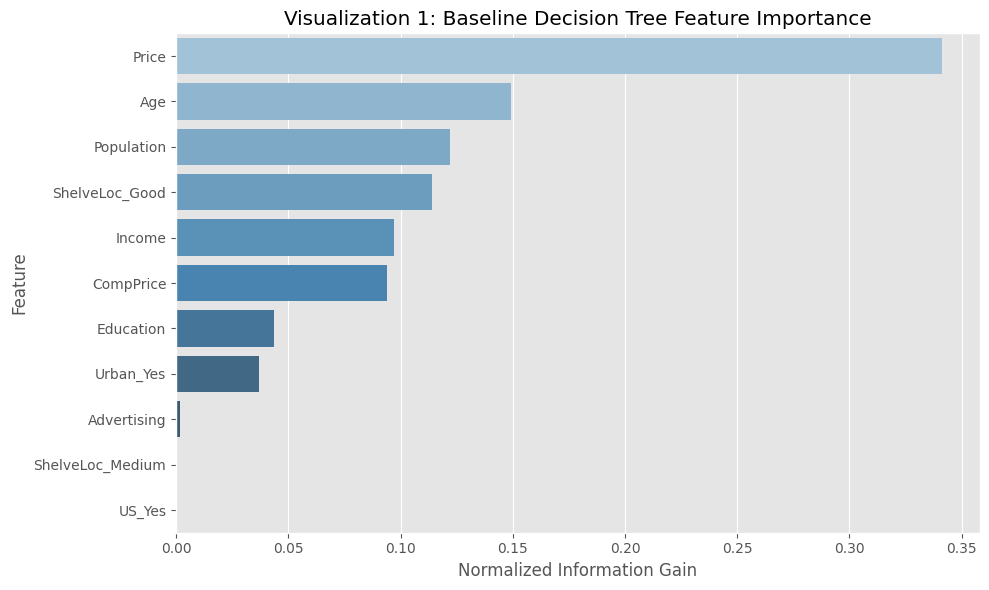

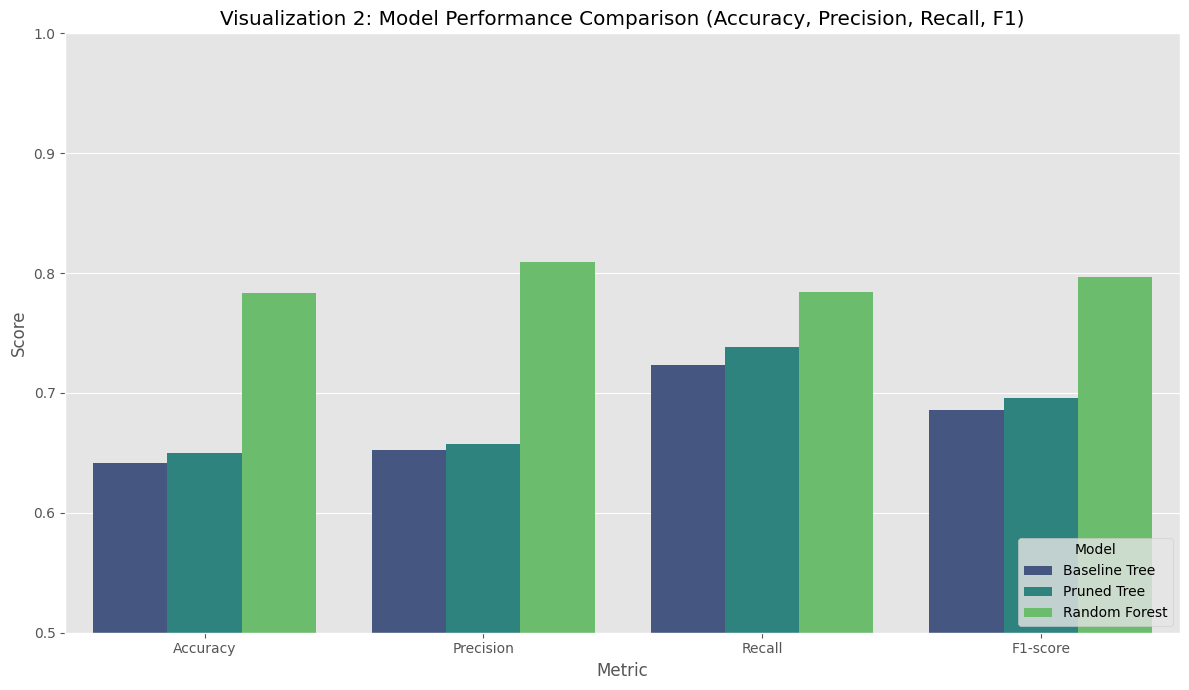

/tmp/ipython-input-2774217184.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_rf.values, y=feature_importances_rf.index, palette="Greens_d")


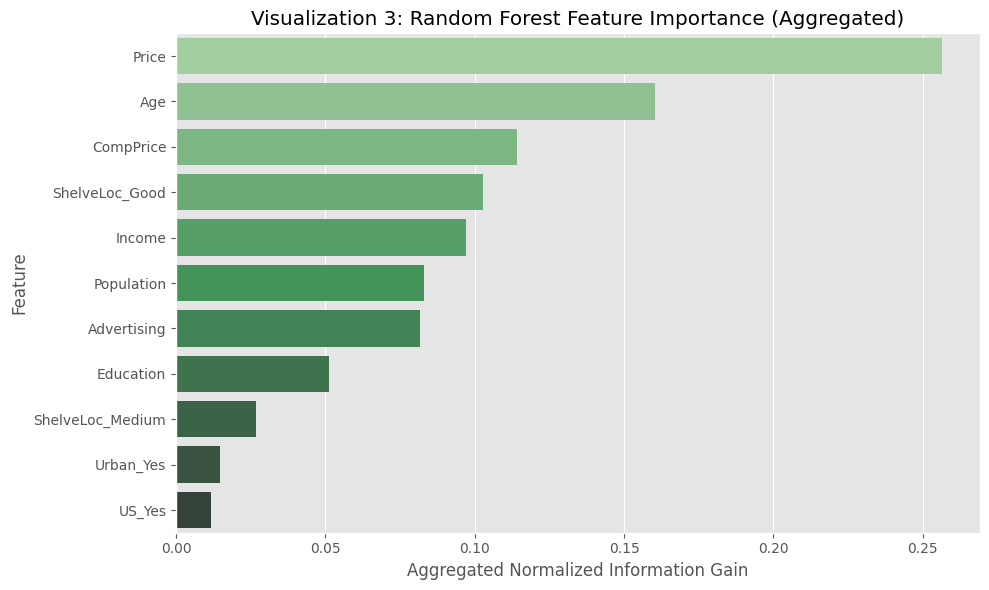

In [ ]:
# Create comparison DataFrame for the report
comparison_df = pd.DataFrame({
    'Metric': list(metrics_baseline.keys()),
    'Baseline Tree': [metrics_baseline[k] for k in metrics_baseline.keys()],
    'Pruned Tree': [metrics_pruned[k] for k in metrics_pruned.keys()],
    'Random Forest': [metrics_rf[k] for k in metrics_rf.keys()]
}).set_index('Metric')

print("\n--- Task 5: Final Performance Comparison Table ---")
print(comparison_df.to_string(float_format='%.4f'))

# --- Visualization 1 (Task 2): Baseline DT Feature Importance ---
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_baseline.values, y=feature_importances_baseline.index, palette="Blues_d")
plt.title('Visualization 1: Baseline Decision Tree Feature Importance')
plt.xlabel('Normalized Information Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- Visualization 2 (Task 5): Model Performance Comparison ---
comparison_df_plot = comparison_df.T.reset_index().rename(columns={'index': 'Model'})
comparison_df_melted = comparison_df_plot.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_df_melted, palette='viridis')
plt.title('Visualization 2: Model Performance Comparison (Accuracy, Precision, Recall, F1)')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.legend(title='Model', loc='lower right')
plt.tight_layout()
plt.show()

# --- Visualization 3 (For Report): Random Forest Feature Importance ---
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf.values, y=feature_importances_rf.index, palette="Greens_d")
plt.title('Visualization 3: Random Forest Feature Importance (Aggregated)')
plt.xlabel('Aggregated Normalized Information Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()